# ***Tarea 8. Gradient Boosting***
### Luis Eduardo Jiménez del Muro - 11/04/2025
---

# *Paqueterías*

In [80]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]

from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split

from lightgbm import LGBMRegressor, early_stopping, log_evaluation
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

# *Funciones*

In [84]:
# Gráfica de calibracion
def calibracion(predicciones, y, bins):
    df_calibracion = pd.DataFrame({
        'predicciones':predicciones,
        'y':y
    })
    df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=bins, labels=False) + 1
    grouped = df_calibracion.groupby('bins').mean()
    r2 = r2_score(y_pred=predicciones, y_true=y)
    
    # Gráfica
    plt.plot(grouped['predicciones'], grouped['predicciones'], label='Real', color='red', lw=1.5)
    plt.plot(grouped['predicciones'], grouped['y'], label='Modelo', marker='o', color='cadetblue', ms=4, lw=2)
    plt.title(f'Calibración del modelo \n\n$R²={r2:.4f}$', fontweight='bold', fontsize=16)
    plt.grid(alpha=0.5, ls='--')
    plt.legend()
    plt.show()


# Gráfica de Loss
def loss_plot(train_loss, test_loss):
    plt.plot(train_loss, label='Train', c='cadetblue')
    plt.plot(test_loss, label='Test', c='red')
    plt.title('Loss', fontweight='bold', fontsize=16)
    plt.xlabel('Iteraciones', fontsize=12)
    plt.ylabel('RMSE', fontsize=12)
    plt.grid(alpha=0.5, ls='--')
    plt.legend()
    plt.show()


# Gráfica de importancia de variables
def importance_weight(model):
    lgb.plot_importance(model, max_num_features=10, importance_type='split', zorder=2, grid=False, color='cadetblue')
    plt.title('Importancia (Weight)', fontweight='bold', fontsize=16)
    plt.grid(alpha=0.5, ls='--', axis='x', zorder=0)
    plt.ylabel('Variable', fontsize=14)
    plt.xlabel('Importancia', fontsize=14)
    plt.show()


# Regresión Polinómica grado n
def polynomial(X, y, type, n, q):
    scaler = StandardScaler().fit(X)
    X_scaled = scaler.transform(X)

    poly_features = PolynomialFeatures(degree=n)
    X_poly = poly_features.fit_transform(X_scaled)
    X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=42)

    model = type.fit(X_train, y_train)
    predicciones_poly_2 = model.predict(X_test)
    calibracion(predicciones_poly_2, y_test, q)


# LightGBM
def lgbm(X, y, q):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    model = LGBMRegressor(
        num_iterations=100_000,
        num_leaves=10,
        learning_rate=0.1,
        max_depth=6,
        lambda_l2=0.1,
        subsample=0.5,
        feature_fraction=0.8,
        verbosity=-1,
        metric='rmse'
    )

    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
            callbacks=[early_stopping(20),
                        log_evaluation(100)])
    predicciones = model.predict(X_test)

    model.evals_result_.keys()
    train_loss = model.evals_result_['training']['rmse']
    test_loss = model.evals_result_['valid_1']['rmse']

    calibracion(predicciones, y_test, q)
    loss_plot(train_loss, test_loss)
    importance_weight(model)

# *Preparar los datos*

In [3]:
df = pd.read_csv('data/Boston.csv')
df = df.drop(columns=['Unnamed: 0'])
df = pd.get_dummies(df, columns=['rad'])
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,tax,ptratio,...,medv,rad_1,rad_2,rad_3,rad_4,rad_5,rad_6,rad_7,rad_8,rad_24
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,296,15.3,...,24.0,True,False,False,False,False,False,False,False,False
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,242,17.8,...,21.6,False,True,False,False,False,False,False,False,False
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,242,17.8,...,34.7,False,True,False,False,False,False,False,False,False
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,222,18.7,...,33.4,False,False,True,False,False,False,False,False,False
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,222,18.7,...,36.2,False,False,True,False,False,False,False,False,False


# *Regresión Lineal Grado 1 (para comparar con el modelo más sencillo)*

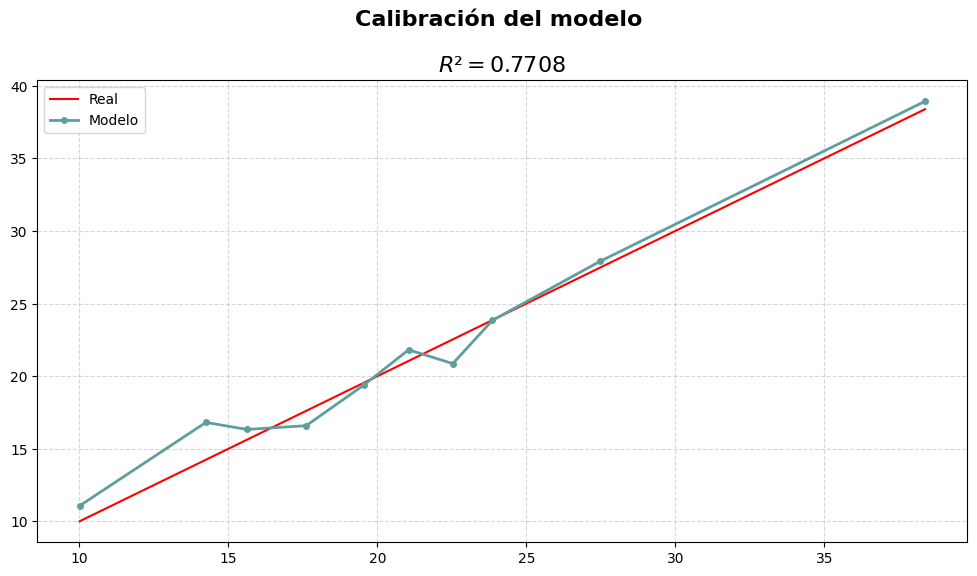

In [82]:
target = 'medv'
X = df.copy().drop(target, axis=1)
y = df[target]

polynomial(X, y, LinearRegression(), 2, 10)

# *Light GBM*

Training until validation scores don't improve for 20 rounds
[100]	training's rmse: 1.78161	valid_1's rmse: 3.32032
Early stopping, best iteration is:
[90]	training's rmse: 1.88619	valid_1's rmse: 3.30426


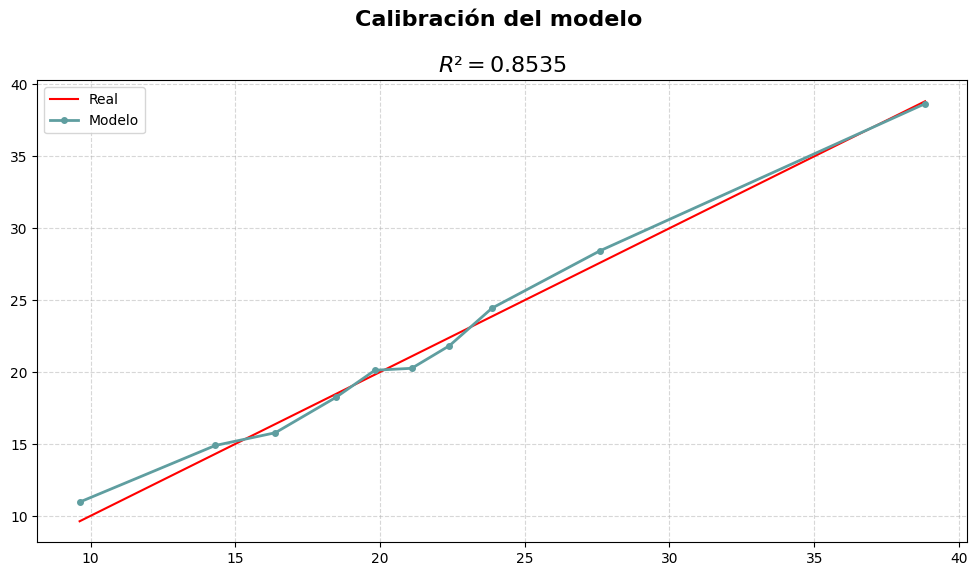

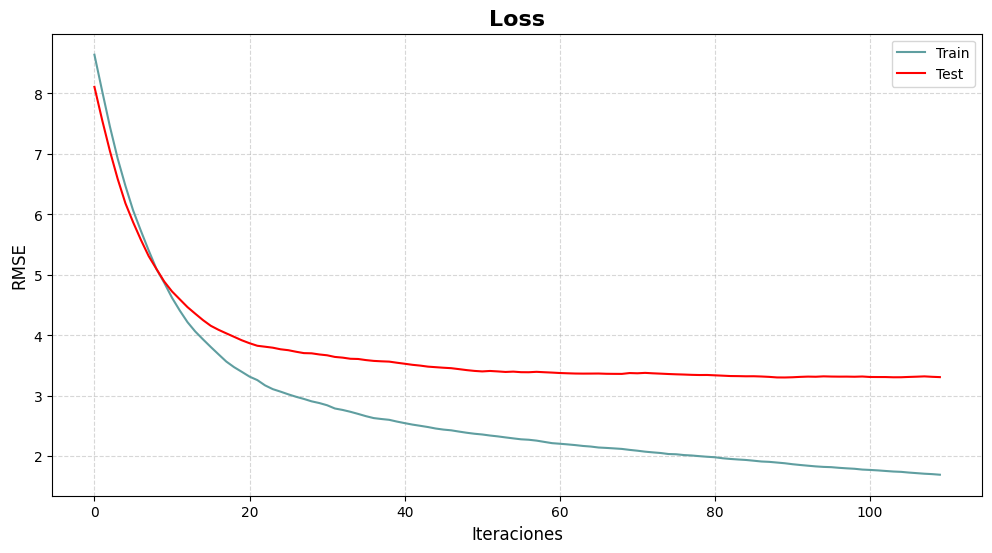

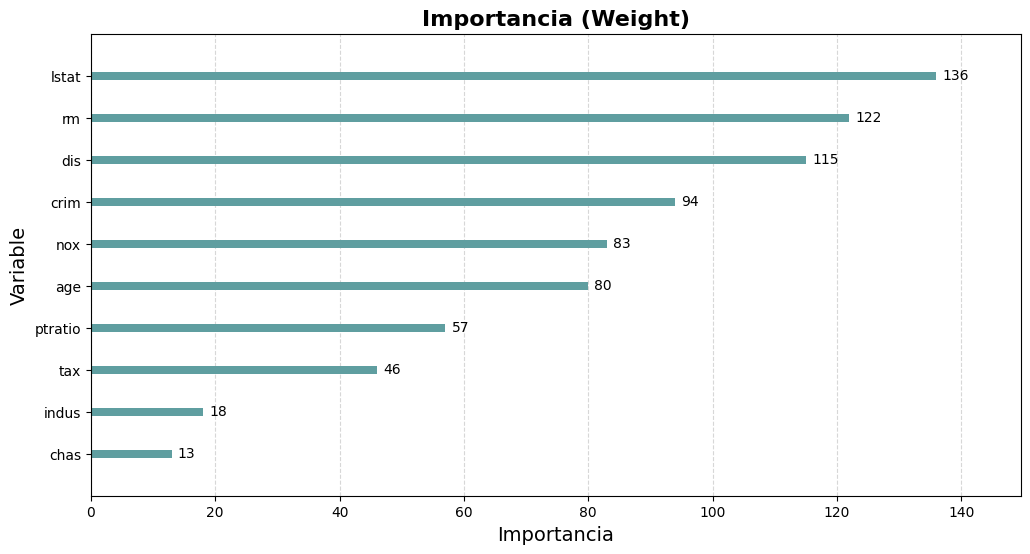

In [85]:
lgbm(X, y, 10)